In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import pickle
from scipy.optimize import curve_fit

from utils import downloadData
from utils import dataProc

In [2]:
#Using Pickle to save time during data loading
read = 0
if read:
    data = dataProc.dataProc()
    df = data.loadData()
    df_dict = data.cleanData(df)
    with open('df_dict.pickle', 'wb') as handle:
        pickle.dump(df_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('df_dict.pickle', 'rb') as handle:
    df_dict = pickle.load(handle)

In [3]:
# Missing step from cleanData
for i in df_dict.keys():
    df_dict[i]=df_dict[i].dropna(axis=1, thresh=5) #delete rows with just nan values
    df_dict[i].columns = df_dict[i].columns.str.replace(' ', '') 

In [32]:
#extract all production data in a single df 
def grouping_field(df_dict):
    df = {}
    for i in df_dict.keys():
        df_temp = df_dict[i].groupby('campo').sum() # Grouping as needed
        January =  df_temp.columns.get_loc('enero')# picking the group first month location
        if (i == '2014'):
            df_temp['noviembre'] = 0.0
            df_temp['diciembre'] = 0.0
        df[i] = df_temp.loc[:, 'enero'::]# Assign clean table
    return df

In [28]:
def actual_data(campo, df):
    production = np.array([])
    dates = pd.date_range(f'2000-01-01', periods=0, freq='M')

    #Actual data
    for i in df.keys():
        if campo in df[i].index:
            dates = np.append(dates, pd.date_range(f'{i}-01-01', periods= df[i].loc[campo,:].size, freq='M'))
            production = np.append(production, df[i].loc[campo,:])
    
    max_prod = np.max(production)
    a = np.where(production == max_prod)[0][0]
    t_data  = dates[a::]
    prod_data = production[a::]
    
    return production, dates, max_prod, t_data, prod_data


def rate_arps_hyp(times, Di):
    # Arps, hyperbolic, b = 0.5 
    # Decline rate, D, in hyperbolic is not constant ( D = - 1/q * dq/dt ) but the initial Di can be obtained
    global production, b_arps, max_prod
    t = np.arange(times.size)
    q = max_prod/(1. + b_arps*Di*t)**(1/b_arps)
    return q

def decline_rate(times, Di):
    global b_arps
    t = np.arange(times.size)
    D = Di / (1+b_arps*Di*t)
    return D

Arps equation for Hyperbolic rate:\\

$ q(t) = q_i / (1.0 + b D_i t)^\frac{1}{b}$

In [ ]:
#Grouping data from a particular dictionary of data. Generalizing to handle the blind test
df = grouping_field(df_dict)

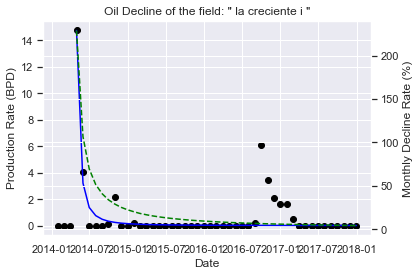

In [33]:
#Selecting field and hyperbolic exponent
campo = "la creciente i"
b_arps = 0.5

#Getting actual production data
production, dates, max_prod, t_data, prod_data = actual_data(campo, df)

#Optimizing decline rate
Di_opt, Di_cov = curve_fit(rate_arps_hyp, t_data, prod_data)

# Plotting data and fit
fig = plt.figure()
ax1 = plt.axes()
ax1.set_xlabel('Date')
ax1.set_ylabel('Production Rate (BPD)')
ax1.set_title(f'Oil Decline of the field: " {campo} "')

ax1.plot(dates, production,'o', color = 'black', label = 'Actual data')
ax1.plot(t_data, rate_arps_hyp(t_data, Di_opt),'-', color = 'blue', label = 'Arps')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Monthly Decline Rate (%)')
ax2.plot(t_data, decline_rate(t_data, Di_opt)*100,'--', color = 'green', label = 'Decline rate')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()